Tentar realizar algum tipo de otimização de oferecimento de ofertas

# 1. Importando bibliotecas e dados

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from joblib import load
import os

import shap
shap.initjs()

import sys
sys.path.append('../src/')

from Model import Model
from offer_opt_functions import *

c:\Users\dpgab\anaconda3\envs\ifoodcase_311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_offers = pd.read_csv("../data/processed/offers_for_modeling.csv")

account_cluster = pd.read_csv("../data/processed/profile_clustered_id.csv")

# Join para acrescentar cluster na tabela antes da modelagem
all_offers = (pd.merge(all_offers, account_cluster,
    on="account_id", how="left")
)

del(account_cluster)

# Aplicar one-hot encoding apenas nas colunas endógenas
df_encoded = pd.get_dummies(all_offers[endogenous_cat_cols], prefix=endogenous_cat_cols, drop_first=False, dtype=float)

# Definindo todas as variáveis do modelo
endogenous_cols = endogenous_cols + list(df_encoded.columns)
X_cols = endogenous_cols + exogenous_cols

# Concatenar com as colunas exógenas
all_offers = pd.concat(
    [
        all_offers,
        df_encoded
    ],
    axis=1
)

# Coletando todos os clusters
unique_clusters = list(all_offers[cluster_col].sort_values().unique())

all_offers.head()

,offer_id,account_id,offer_received_date,channel_mobile,channel_email,channel_social,channel_web,offer_type,TARGET_USED_OFFER,account_id.1,...,total_web_offer,total_offers_bogo,total_offers_discount,total_offers_informational,discount_value,offer_duration,offer_min_value,cluster,offer_type_bogo,offer_type_discount
0,4d5c57ea9a6940dd891ad53e9dbe8da0,0020c2b971eb4e9188eac86d93036a77,17.0,1,1,1,1,bogo,1,NaN,...,03_Entre_4_e_6,02_Entre_1_e_2,04_Acima_de_3,01_Abaixo_de_1,10,5.0,10,7,1.0,0.0
1,ae264e3637204a6fb9bb56bc8210ddfd,0020c2b971eb4e9188eac86d93036a77,7.0,1,1,1,0,bogo,0,NaN,...,03_Entre_4_e_6,02_Entre_1_e_2,04_Acima_de_3,01_Abaixo_de_1,10,7.0,10,7,1.0,0.0
2,fafdcd668e3743c1bb461111dcafc2a4,0020c2b971eb4e9188eac86d93036a77,0.0,1,1,1,1,discount,1,NaN,...,03_Entre_4_e_6,02_Entre_1_e_2,04_Acima_de_3,01_Abaixo_de_1,2,10.0,10,7,0.0,1.0
3,fafdcd668e3743c1bb461111dcafc2a4,0020c2b971eb4e9188eac86d93036a77,0.0,1,1,1,1,discount,1,NaN,...,03_Entre_4_e_6,02_Entre_1_e_2,04_Acima_de_3,01_Abaixo_de_1,2,10.0,10,7,0.0,1.0
4,fafdcd668e3743c1bb461111dcafc2a4,0020c2b971eb4e9188eac86d93036a77,14.0,1,1,1,1,discount,1,NaN,...,03_Entre_4_e_6,02_Entre_1_e_2,04_Acima_de_3,01_Abaixo_de_1,2,10.0,10,7,0.0,1.0


In [3]:
models = get_all_joblib("../src/models")
model_keys = list(models.keys())

# 2. Shap

Analise shap do cluster 5


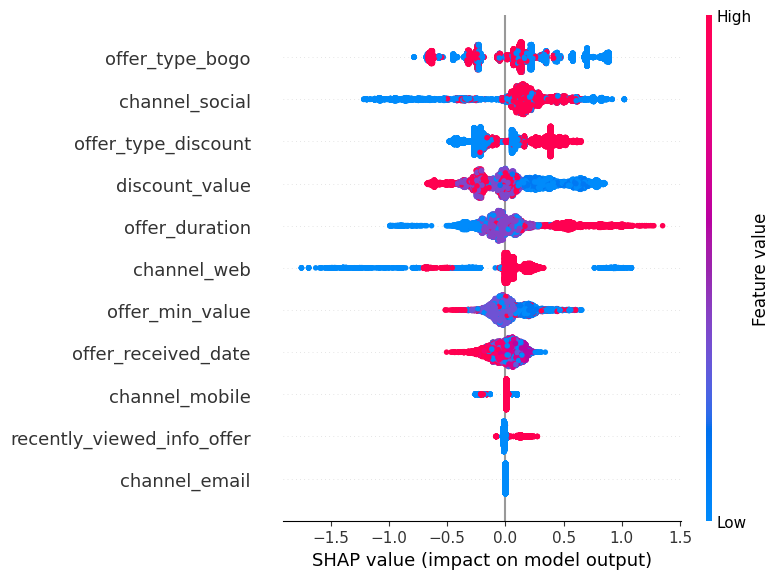

In [138]:
for cl in models:
    if cl != 5: continue
    model = models[cl].model
    cl_X = all_offers[all_offers["cluster"] == cl][X_cols]
    cl_y = all_offers[all_offers["cluster"] == cl][y_col]

    # Gerando Shap Score
    explainer = shap.Explainer(model)
    shap_values = explainer(cl_X)

    # Selecionando features especificas
    print(f"Analise shap do cluster {cl}")
    shap_values_selected = pd.DataFrame(shap_values.values, columns=cl_X.columns)
    shap_values_selected = shap_values_selected[endogenous_cols + ["recently_viewed_info_offer"]]
    selected_cl_X = cl_X[endogenous_cols + ["recently_viewed_info_offer"]]

    # Gerando gráfico apenas com as variáveis endógenas
    shap.summary_plot(np.array(shap_values_selected), selected_cl_X) # Selecionadas

In [147]:
main_features = {
    1: {
        "channel_social": 1,
        "channel_web": 1,
        "discount_value": "low",
        "offer_type_discount": 1,
        "offer_min_value": "low",
        "offer_duration": "low",
        "channel_mobile": 1,
        "offer_type_bogo": 0,
        "offer_receive_date": "keep",
        "channel_email": 0,
        "obs": "",
    },
    2: {
        "channel_social": 1,
        "channel_web": 1,
        "discount_value": "low",
        "offer_type_discount": 1,
        "offer_min_value": "low",
        "offer_duration": "high",
        "channel_mobile": 0,
        "offer_type_bogo": 0,
        "offer_receive_date": "keep",
        "channel_email": 0,
        "obs": "",
    },
    4: {
        "channel_social": "keep",
        "channel_web": "keep",
        "discount_value": "keep",
        "offer_type_discount": "keep",
        "offer_min_value": "low",
        "offer_duration": "high",
        "channel_mobile": "keep",
        "offer_type_bogo": "keep",
        "offer_receive_date": "keep",
        "channel_email": 0,
        "obs": "",
    },
    5: {
        "channel_social": 1,
        "channel_web": 1,
        "discount_value": "keep",
        "offer_type_discount": 1,
        "offer_min_value": "keep",
        "offer_duration": "high",
        "channel_mobile": 1,
        "offer_type_bogo": 0,
        "offer_receive_date": "keep",
        "channel_email": 0,
        "obs": "Visualizar uma oferta informativa parece influenciar positivamente"
    },
    6: {
        "channel_social": 1,
        "channel_web": 1,
        "discount_value": "low",
        "offer_type_discount": 1,
        "offer_min_value": "low",
        "offer_duration": "keep",
        "channel_mobile": 1,
        "offer_type_bogo": 0,
        "offer_receive_date": "keep",
        "channel_email": 0,
        "obs": ""
    },
    7: {
        "channel_social": 1,
        "channel_web": 1,
        "discount_value": "low",
        "offer_type_discount": 0,
        "offer_min_value": "low",
        "offer_duration": "high",
        "channel_mobile": 1,
        "offer_type_bogo": 1,
        "offer_receive_date": "keep",
        "channel_email": 0,
        "obs": ""
    },
}

# 3. Otimizando features de acordo com o shap

In [151]:
for cl in models:
    model = models[cl].model
    cl_X = all_offers[all_offers["cluster"] == cl][X_cols]
    cl_y = all_offers[all_offers["cluster"] == cl][y_col]

    # Predição com dados originais
    unchanged_offer_usage = sum(model.predict(cl_X))

    # Modificando valores de acordo com shap
    mod_X = modify_features(cl_X, main_features[cl])

    # Predição com modificação nos dados de acordo com shap
    changed_offer_usage = sum(model.predict(mod_X))

    print(f"Cluster {cl}: +{round((changed_offer_usage / unchanged_offer_usage - 1) * 100, 1)}%")
    # print(f"{changed_offer_usage:,} {unchanged_offer_usage:,}")



Cluster 1: +2.5%
Cluster 2: +43.1%
Cluster 4: +0.8%
Cluster 5: +2.8%
Cluster 6: +90.7%
Cluster 7: +16.3%
